## Check BELUGA L2 netCDF files

This notebook is used to present the nc architecture of the processed BELUGA L2-data for the BP and TMP instrument probe (met and turb component). The notebook aims to check whether the variables are provided with correct units and attributes, whether the coordinates match, the global attributes are correct and whether the data follows the CF-conventions.

You can choose the research flight number for which you want to inspect and check the data. 
Caution, for some RFs, there is not data available for each of the instrument probes. 

In [1]:
import glob
import os
import sys
import warnings
import pandas as pd
import xarray as xr
warnings.filterwarnings("ignore")

import STN_flight_information
sys.path.insert(1,os.getcwd()+"/../plotting/")
import checkL2plots

#### Get campaign flight information
Table of RFs with some information on ABL transition type, profiles and overall data quality

In [2]:
flight_infos=STN_flight_information.get_flight_information()
flight_infos

,Date,Start Time,End Time,type,No_of_profiles,Max_height,TMP_met_data_quality,TMP_turb_data_quality,BP_data_quality
Flight No,,,,,,,,,
RF01,24/03/2024,2024-03-24 12:32:56,2024-03-24 14:38:13,uncategorized,8.0,378.0,good,unavailable,unavailable
RF02,24/03/2024,2024-03-24 15:33:41,2024-03-24 16:41:32,uncategorized,4.0,451.0,good,unavailable,unavailable
RF03,25/03/2024,2024-03-25 10:09:08,2024-03-25 13:56:33,uncategorized,16.0,487.0,good,unavailable,good
RF04,25/03/2024,2024-03-25 15:05:26,2024-03-25 16:25:43,uncategorized,6.0,406.0,unavailable,unavailable,good
RF05,26/03/2024,2024-03-26 16:07:39,2024-03-26 18:25:35,Polar night to day,10.0,482.0,good,unavailable,good
RF06,26/03/2024,2024-03-26 19:09:02,2024-03-26 21:57:37,Polar night to day,10.0,466.0,good,unavailable,good
RF07,27/03/2024,2024-03-27 16:11:40,2024-03-27 17:42:30,clear to cloudy,6.0,480.0,good,unavailable,good
RF08,28/03/2024,2024-03-28 09:56:12,2024-03-28 12:48:06,clear to cloudy,12.0,494.0,good,unavailable,good
RF09,28/03/2024,2024-03-28 00:00:00,2024-03-28 00:00:00,uncategorized,NaN,NaN,unavailable,unavailable,unavailable


# Allocation

In [3]:
# Research flight to check, you define the flight
flight="RF13" # ranges from RF01 to RF28
version_to_check="_v2.5"

In [4]:
# Define data paths
date            = flight_infos["Date"][flight][-4:]+flight_infos["Date"][flight][-7:-5]+flight_infos["Date"][flight][-11:-8]
overall_path    = os.getcwd()+"/../BELUGA_data/"
BP_l2_file_path = overall_path+"BELUGA_broadband_probe/final_data/"
TM_l2_file_path = overall_path+"BELUGA_TMP_met_probe/final_data/"
TU_l2_file_path = overall_path+"BELUGA_TMP_turb_probe/final_data/"
RS_l2_file_path = overall_path+"radiosondes/final_data/"
BP_l2_fname     = "BELUGA_STN_L2_BP_"+flight+"_"+date+version_to_check+".nc"
TM_l2_fname     = "BELUGA_STN_L2_TMP_met_"+flight+"_"+date+version_to_check+".nc" 
TU_l2_fname     = "BELUGA_STN_L2_TMP_turb_"+flight+"_"+date+version_to_check+".nc"

# Broadband probe data

In [5]:
# read file
BP_file_existent=len(glob.glob(BP_l2_file_path+BP_l2_fname))>0
if BP_file_existent:
    BP_ds=xr.open_dataset(BP_l2_file_path+BP_l2_fname)
else:
    BP_ds=xr.Dataset()
    no_data_info="No data from BP probe available for "+flight
    BP_ds.attrs["no data"]=no_data_info
    print(no_data_info)

In [6]:
# show dataset
BP_ds

<xarray.Dataset>
Dimensions:          (time: 8762)
Coordinates:
  * time             (time) datetime64[ns] 2024-04-01T12:23:51 ... 2024-04-01...
Data variables: (12/17)
    F_up             (time) float64 ...
    F_down           (time) float64 ...
    F_net            (time) float64 ...
    bme_temperature  (time) float64 ...
    bme_pressure     (time) float64 ...
    bme_rh           (time) float64 ...
    ...               ...
    z_b              (time) float64 ...
    flight_segments  (time) float64 ...
    lat              float64 ...
    lon              float64 ...
    STN_height       float64 ...
    flight_id        float64 ...
Attributes: (12/20)
    title:                Tethered balloon-borne broadband thermal-infrared i...
    authors:              Dorff, Henning; Schaefer, Michael; Siebert, Holger;...
    institutes:            (1) Leipzig Institute for Meteorology, Leipzig, Ge...
    contact:              henning.dorff@uni-leipzig.de, a.ehrlich@uni-leipzig...
    abstract:             The tethered balloon system BELUGA (Balloon-bornE m...
    campaign:             Measurement campaign at Station Nord (Greenland) in...
    ...                   ...
    Conventions:          CF-1.12
    licence:              Creative Commons Attribution NonCommercialShareAlik...
    featureType:          TimeSeries
    keywords:             Atmospheric boundary layer (ABL); Arctic; BELUGA; B...
    flight:               RF13
    ABL_transition_type:  low-level jet

In [7]:
BP_ds["z_b"].max()

<xarray.DataArray 'z_b' ()>
array(471.99331647)

bad data: 0  of  8762  time steps
ok data: 253  of  8762  time steps
good data: 8509  of  8762  time steps


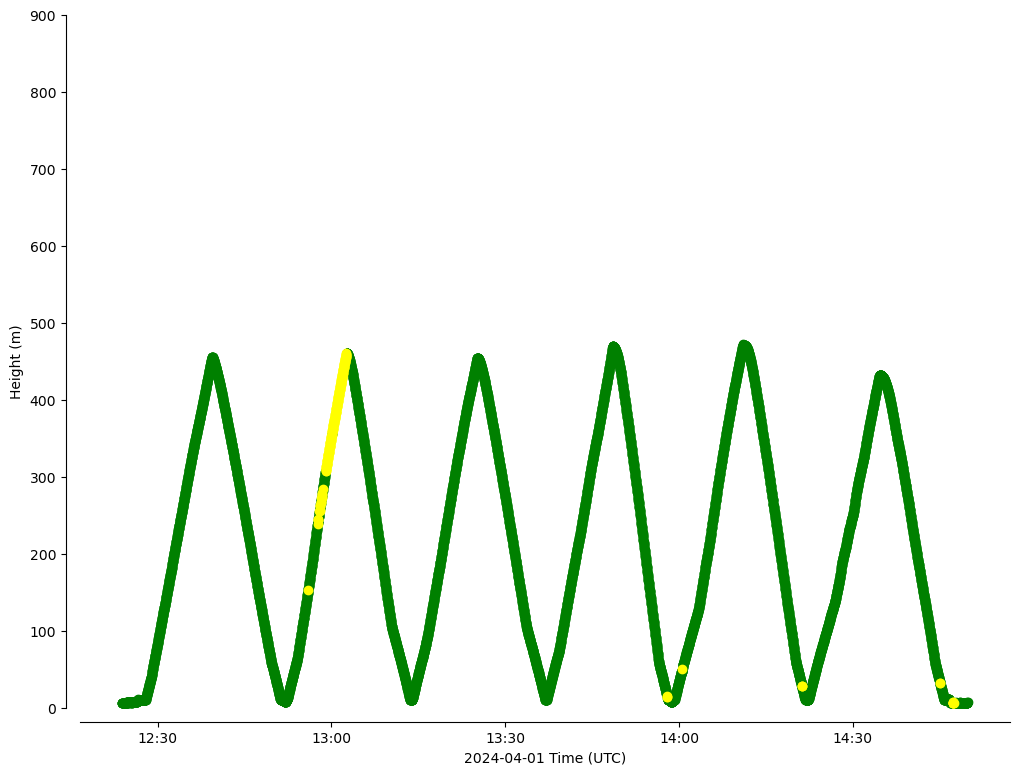

In [8]:
if BP_file_existent:
    checkL2plots.plot_series_quality_flag(BP_ds,probe="BP")

# Turbulent meteorological probe (met)

In [9]:
# read file
TM_file_existent=len(glob.glob(TM_l2_file_path+TM_l2_fname))>0
if TM_file_existent:
   TM_ds=xr.open_dataset(TM_l2_file_path+TM_l2_fname)
else:
    TM_ds=xr.Dataset()
    no_data_info="No data from the meteorological component of the TMP probe available for "+flight
    TM_ds.attrs["no data"]=no_data_info
    print(no_data_info)
    # show quality

In [10]:
TM_ds

<xarray.Dataset>
Dimensions:          (time: 8275)
Coordinates:
  * time             (time) datetime64[ns] 2024-04-01T12:27:55 ... 2024-04-01...
Data variables: (12/16)
    p                (time) float64 ...
    z_b              (time) float64 ...
    T                (time) float64 ...
    sonic_T          (time) float64 ...
    rh               (time) float64 ...
    vv               (time) float64 ...
    ...               ...
    quality_flag     (time) float64 ...
    flight_segments  (time) float64 ...
    lat              float64 ...
    lon              float64 ...
    STN_height       float64 ...
    flight_id        float64 ...
Attributes: (12/20)
    title:                Tethered balloon-borne meteorological profile measu...
    authors:              Dorff, Henning; Siebert, Holger; Schaefer, Michael;...
    institutes:            (1) Leipzig Institute for Meteorology, Leipzig Uni...
    contact:              henning.dorff@uni-leipzig.de, a.ehrlich@uni-leipzig...
    abstract:             The tethered balloon system BELUGA (Balloon-bornE m...
    campaign:             Collaborative measurement campaign at Station Nord ...
    ...                   ...
    Conventions:          CF-1.12
    licence:              Creative Commons Attribution NonCommercialShareAlik...
    featureType:          TimeSeries
    keywords:             Atmospheric boundary layer (ABL); Arctic; BELUGA; T...
    flight:               RF13
    ABL_transition_type:  low-level jet

In [11]:
if TM_file_existent:
    print(TM_ds.time[0],TM_ds.time[-1])

<xarray.DataArray 'time' ()>
array('2024-04-01T12:27:55.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2024-04-01T12:27:55
Attributes:
    long_name:      measurement time (UTC)
    standard_name:  time <xarray.DataArray 'time' ()>
array('2024-04-01T14:45:49.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2024-04-01T14:45:49
Attributes:
    long_name:      measurement time (UTC)
    standard_name:  time


bad data: 0  of  8275  time steps
ok data: 345  of  8275  time steps
good data: 7930  of  8275  time steps


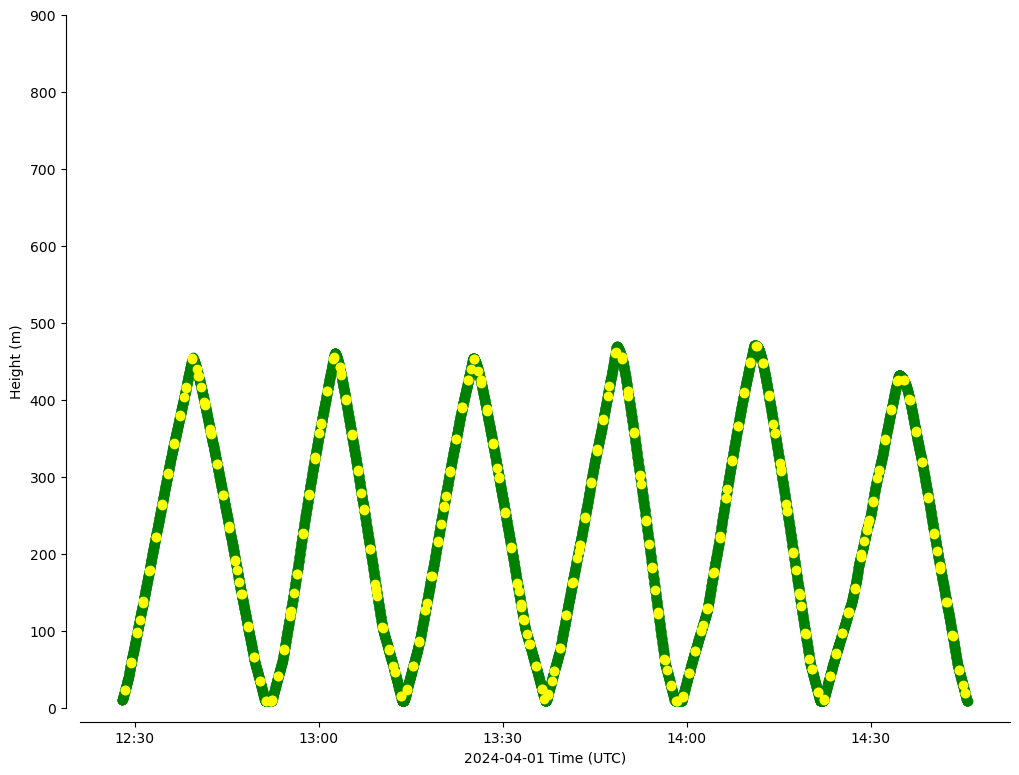

In [12]:
# show quality
if TM_file_existent:
    checkL2plots.plot_series_quality_flag(TM_ds)

In [13]:
# show quality
#if TM_file_existent:
#    testplots.show_data_quality(TM_ds,"turbulence meteorological probe")

# Turbulent meteorological probe (turb)

In [14]:
# read file
TU_file_existent=len(glob.glob(TU_l2_file_path+TU_l2_fname))>0
if TU_file_existent:
    TU_ds=xr.open_dataset(TU_l2_file_path+TU_l2_fname)
    print(TU_ds["U"].time[0],TU_ds["U"].time[-1])
else:
    TU_ds=xr.Dataset()
    no_data_info="No data from the turbulent component of the TMP probe available for "+flight
    TU_ds.attrs["no data"]=no_data_info
    print(no_data_info)

<xarray.DataArray 'time' ()>
array('2024-04-01T12:27:55.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2024-04-01T12:27:55
Attributes:
    long_name:      measurement time (UTC)
    standard_name:  time <xarray.DataArray 'time' ()>
array('2024-04-01T14:45:28.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2024-04-01T14:45:28
Attributes:
    long_name:      measurement time (UTC)
    standard_name:  time


In [15]:
# show data
TU_ds

<xarray.Dataset>
Dimensions:          (time: 412651)
Coordinates:
  * time             (time) datetime64[ns] 2024-04-01T12:27:55 ... 2024-04-01...
Data variables:
    p                (time) float64 ...
    T                (time) float64 ...
    E_U              (time) float64 ...
    rho              (time) float64 ...
    U                (time) float64 ...
    z_b              (time) float64 ...
    flight_segments  (time) float64 ...
    lat              float64 ...
    lon              float64 ...
    STN_height       float64 ...
    flight_id        float64 ...
Attributes: (12/20)
    title:                Tethered balloon-borne turbulence profile measureme...
    authors:              Dorff, Henning; Schaefer, Michael; Siebert, Holger;...
    institutes:           (1) Leipzig Institute for Meteorology, Leipzig, Ger...
    contact:              henning.dorff@uni-leipzig.de, a.ehrlich@uni-leipzig...
    abstract:             The tethered balloon system BELUGA (Balloon-bornE m...
    campaign:             Collaborative measurement campaign at Station Nord ...
    ...                   ...
    Conventions:          CF-1.12
    licence:              Creative Commons Attribution NonCommercialShareAlik...
    featureType:          TimeSeries
    keywords:             Atmospheric boundary layer (ABL); Arctic; BELUGA; T...
    flight:               RF13
    ABL_transition_type:  low-level jet

# Plotting

#### Flight segmentation

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\BELUGA_Leipzig_AC3\Code\GIT\BELUGA_STN_measurement_data_processing\notebooks/../plots/RF13/BELUGA_TMP_met_flight_segmentation_RF13.png


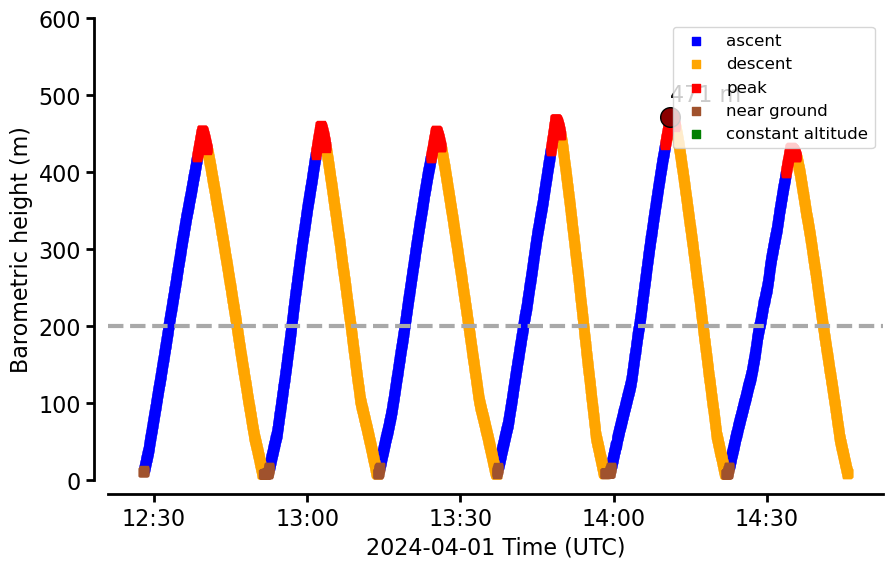

In [16]:
if TM_file_existent:
    segments_df=TM_ds[["z_b","flight_segments"]].to_dataframe()
elif BP_file_existent:
    segments_df=BP_ds[["z_b","flight_segments"]].to_dataframe()
elif TU_file_existent:
    segments_df=TU_ds[["z_b","flight_segments"]].to_dataframe()
else:
    segments_df=pd.DataFrame()
if not segments_df.shape[0]==0:    
    checkL2plots.plot_flight_segmentation(segments_df,flight)

### BP plots

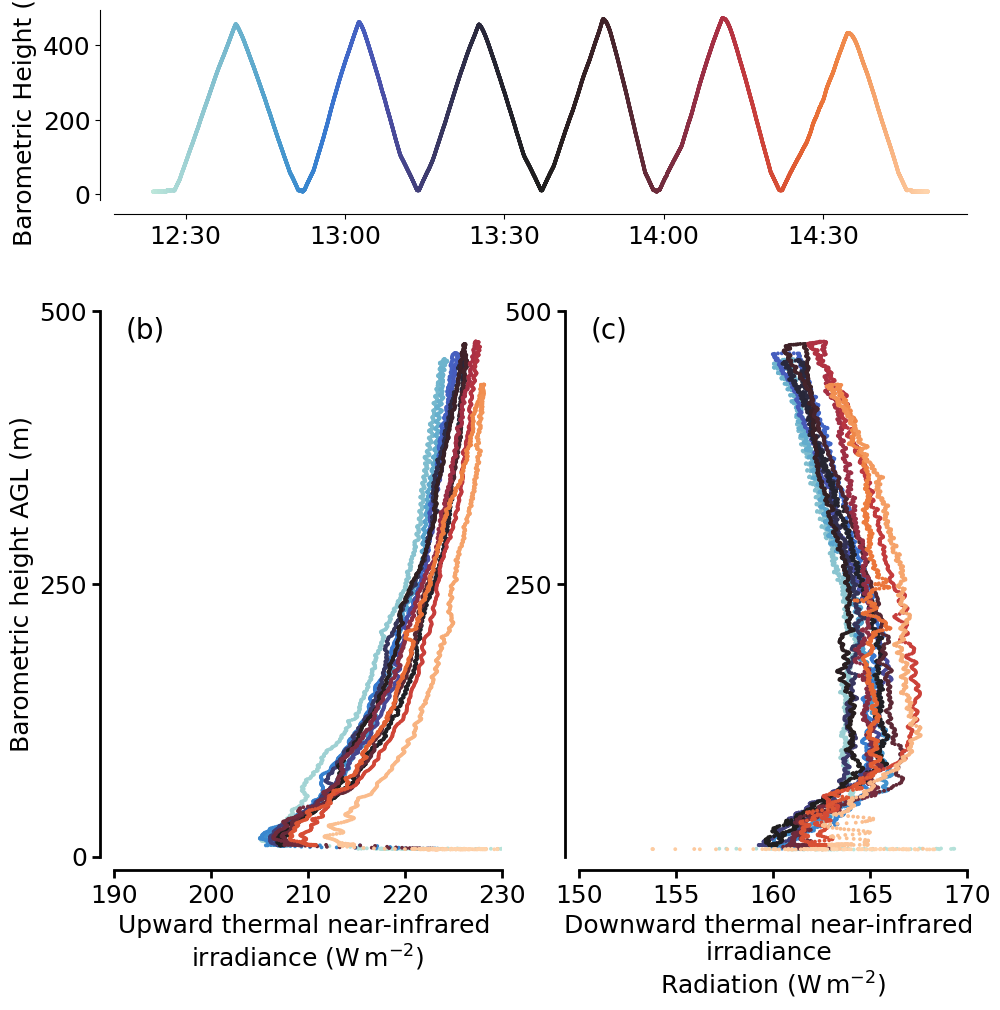

In [17]:
%matplotlib inline
if BP_file_existent:
    checkL2plots.plot_BP_up_and_down_ward_terr_radiation(BP_ds,flight)

<IPython.core.display.Javascript object>


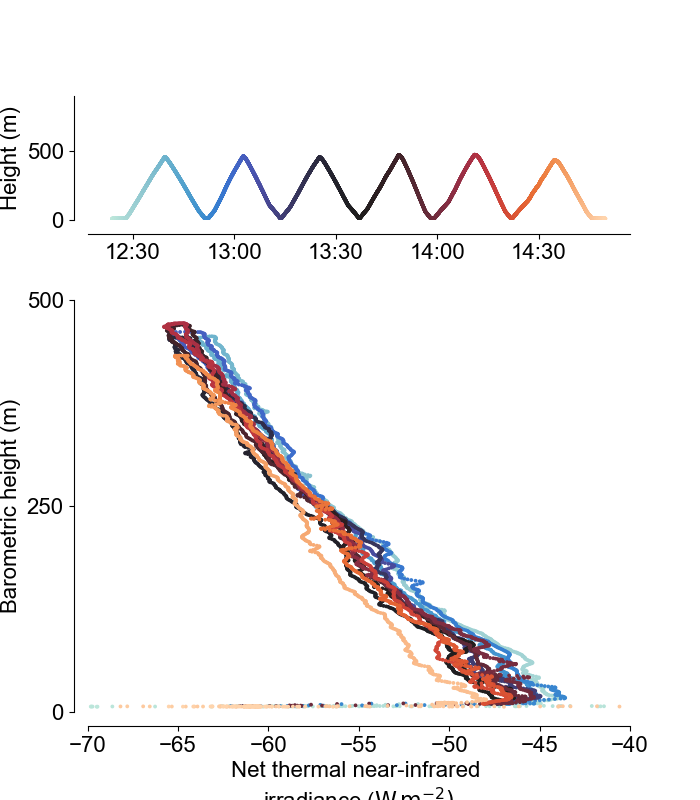

In [18]:
if BP_file_existent:
    %matplotlib notebook
    checkL2plots.plot_BP_net_terr_radiation(BP_ds,flight)

### TMP_met: Overall combined plot

<IPython.core.display.Javascript object>


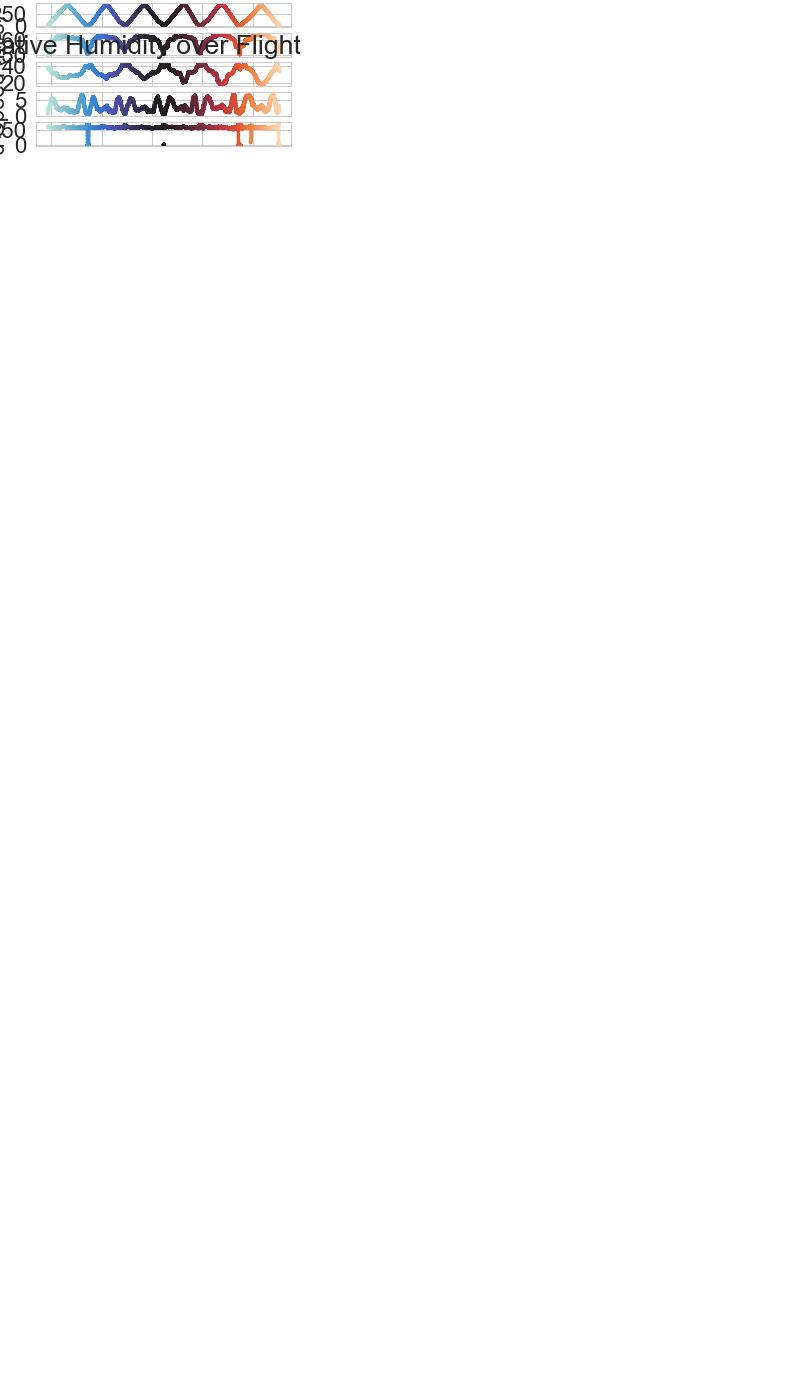

Fig. saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\BELUGA_Leipzig_AC3\Code\GIT\BELUGA_STN_measurement_data_processing\notebooks/../plots/RF13/TMP_met_overview_RF13.png


In [19]:
if TM_file_existent:
    checkL2plots.TMP_met_plot_series_all_vars(TM_ds,flight)

<IPython.core.display.Javascript object>


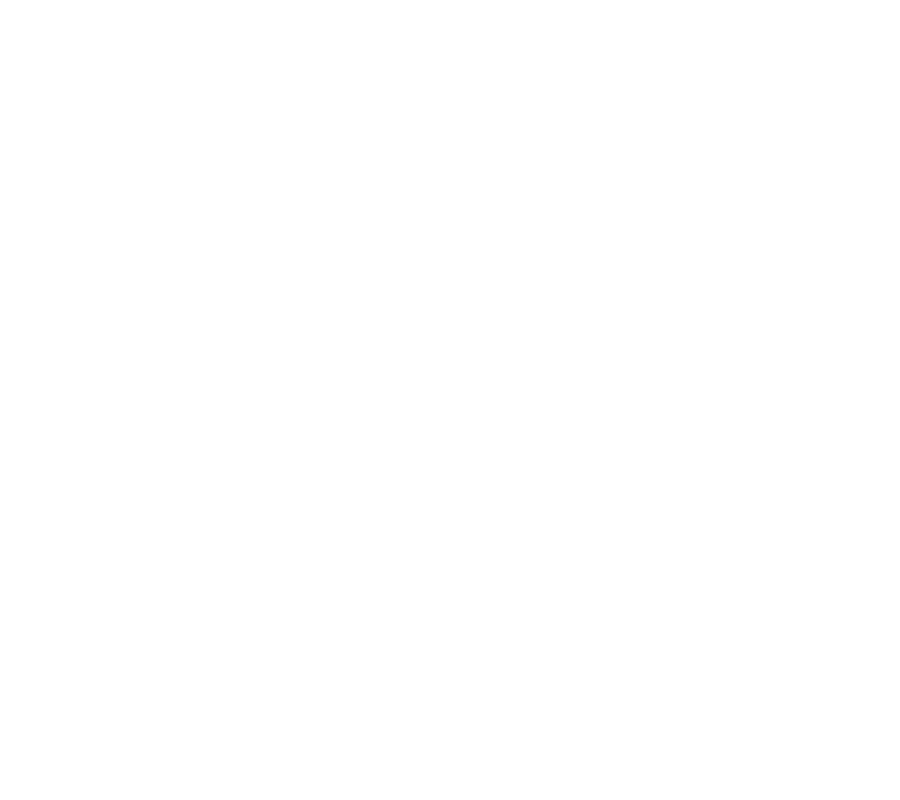

In [20]:
if TM_file_existent:
    var_to_plot="T" # select a variable to be plotted out of ["z_b","T","rh","vv","dd"]
    %matplotlib notebook
    checkL2plots.TMP_met_plot_single_var_time_series(TM_ds,var_to_plot,flight)

<IPython.core.display.Javascript object>


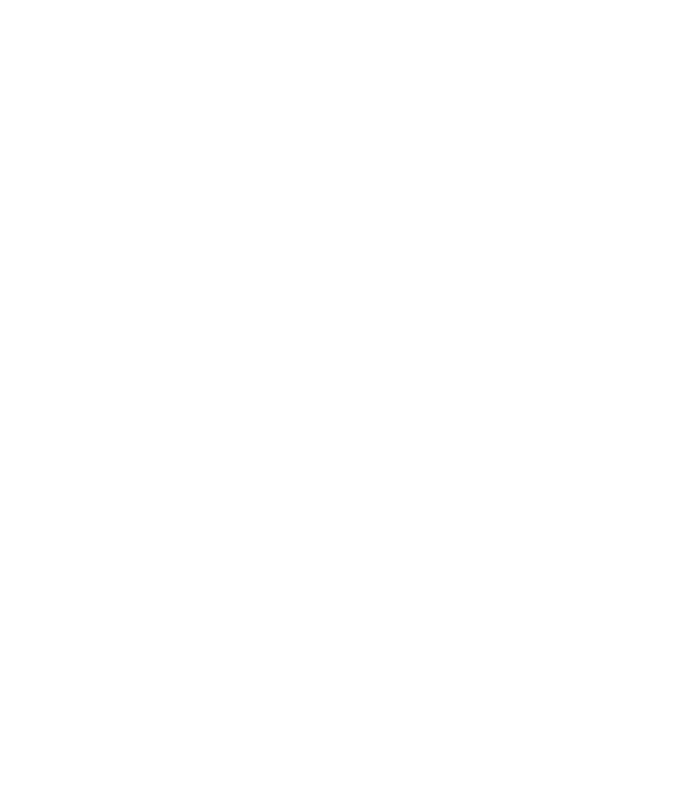

In [21]:
if TM_file_existent:
    checkL2plots.TMP_met_plot_single_var_profile(TM_ds,var_to_plot,flight)

### TMP_turb: Plot 

<IPython.core.display.Javascript object>


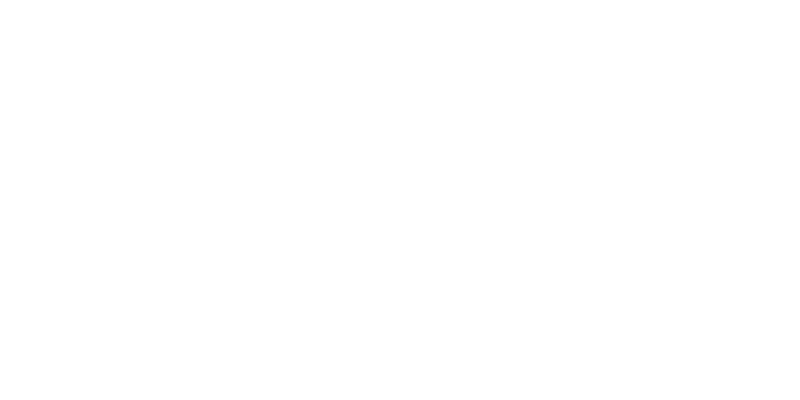

6.5076


In [22]:
if TU_file_existent:
    checkL2plots.plot_TMP_turb_windspeed(TU_ds,flight)

# Datasets Attributes

### Global Attributes BP dataset

In [23]:
if BP_file_existent:
    BP_ds.info()

xarray.Dataset {
dimensions:
	time = 8762 ;

variables:
	float64 F_up(time) ;
		F_up:standard_name = upwelling_longwave_flux_in_air ;
		F_up:long_name = upward terrestrial (long-wave) radiation (irradiance) ;
		F_up:units = W m-2 ;
		F_up:accuracy = 5 W m-2 ;
		F_up:source = Kipp & Zonen CGR4 pyrgeometer ;
	float64 F_down(time) ;
		F_down:standard_name = downwelling_longwave_flux_in_air ;
		F_down:long_name = downward terrestrial (long-wave) radiation (irradiance) ;
		F_down:units = W m-2 ;
		F_down:source = Kipp & Zonen CGR4 pyrgeometer ;
		F_down:accuracy = 5 W m-2 ;
	float64 F_net(time) ;
		F_net:standard_name = net_downward_longwave_flux_in_air ;
		F_net:long_name = net terrestrial (long-wave) radiation.  ;
		F_net:units = W m-2 ;
		F_net:comments = F_net=F_down-F_up, positive if there is downward longwave flux as F_down and F_up values are positively defined. ;
		F_net:accuracy =  7 W m-2 ;
	float64 bme_temperature(time) ;
		bme_temperature:standard_name = air_temperature ;
		bme_

In [24]:
BP_ds.attrs

{'title': 'Tethered balloon-borne broadband thermal-infrared irradiance profile measurement data characterising the Arctic atmospheric boundary layer at Station Nord',
 'authors': 'Dorff, Henning; Schaefer, Michael; Siebert, Holger; Mueller, Joshua; Navale, Komal; Wu, Fan; Ehrlich, Andre; Wendisch, Manfred',
 'institutes': ' (1) Leipzig Institute for Meteorology, Leipzig, Germany Leipzig University; (2) Leibniz Institute for Tropospheric Research e.V., Leipzig, Germany',
 'contact': 'henning.dorff@uni-leipzig.de, a.ehrlich@uni-leipzig.de, siebert@tropos.de',
 'abstract': 'The tethered balloon system BELUGA (Balloon-bornE moduLar Utility for profilinG the lower Atmosphere) was operated during a collaborative measurement campaign at Station Nord (Greenland) in spring 2024 (2024-03-18 to 2024-04-18). BELUGA performed frequent profiling of the Arctic atmospheric boundary layer to examine transitions between typical states of the Arctic atmospheric boundary layer. The balloon payload includ

### Variable attributes

In [25]:
for var in BP_ds.variables:
    print(var,BP_ds[var].attrs,"\n")

F_up {'standard_name': 'upwelling_longwave_flux_in_air', 'long_name': 'upward terrestrial (long-wave) radiation (irradiance)', 'units': 'W m-2', 'accuracy': '5 W m-2', 'source': 'Kipp & Zonen CGR4 pyrgeometer'} 

F_down {'standard_name': 'downwelling_longwave_flux_in_air', 'long_name': 'downward terrestrial (long-wave) radiation (irradiance)', 'units': 'W m-2', 'source': 'Kipp & Zonen CGR4 pyrgeometer', 'accuracy': '5 W m-2'} 

F_net {'standard_name': 'net_downward_longwave_flux_in_air', 'long_name': 'net terrestrial (long-wave) radiation. ', 'units': 'W m-2', 'comments': 'F_net=F_down-F_up, positive if there is downward longwave flux as F_down and F_up values are positively defined.', 'accuracy': ' 7 W m-2'} 

bme_temperature {'standard_name': 'air_temperature', 'long_name': 'measured air temperature', 'units': 'K', 'source': 'BME sensor'} 

bme_pressure {'standard_name': 'air_pressure', 'long_name': 'measured static air pressure', 'units': 'hPa', 'source': 'BME sensor'} 

bme_rh {'st

### Global attributes (TMP_met)

In [26]:
TM_ds.info()

xarray.Dataset {
dimensions:
	time = 8275 ;

variables:
	float64 p(time) ;
		p:standard_name = air_pressure ;
		p:long_name = measured static air pressure ;
		p:units = hPa ;
		p:source = Balloon-borne radiosonde ;
	float64 z_b(time) ;
		z_b:standard_name = barometric_altitude ;
		z_b:long_name = Pressure measurement based barometric altitude ;
		z_b:units = m ;
		z_b:source = Based on radiosonde pressure ;
		z_b:comments = z_b=RL * (T_GND + 273.15) / g * np.log(p_GND / p) ;
	float64 T(time) ;
		T:standard_name = air_temperature ;
		T:long_name = air_temperature_radiosonde ;
		T:units = K ;
		T:source = Balloon-borne radiosonde ;
	float64 sonic_T(time) ;
		sonic_T:standard_name = air_temperature ;
		sonic_T:long_name = sensor_temperature_sonic_anemometer ;
		sonic_T:units = K ;
		sonic_T:source = Ultra-sonic anemometer ;
		sonic_T:comments = corrected for a mean offset compared to sonde-based T ;
	float64 rh(time) ;
		rh:standard_name = relative_humidity ;
		rh:long_name = measured rel

In [27]:
TM_ds.attrs

{'title': 'Tethered balloon-borne meteorological profile measurement data characterising the Arctic atmopsheric boundary layer at Station Nord',
 'authors': 'Dorff, Henning; Siebert, Holger; Schaefer, Michael; Mueller, Joshua; Navale, Komal; Wu, Fan; Ehrlich, Andre; Wendisch, Manfred',
 'institutes': ' (1) Leipzig Institute for Meteorology, Leipzig University; (2) Leibniz Institute for Tropospheric Research e.V., Leipzig, Germany',
 'contact': 'henning.dorff@uni-leipzig.de, a.ehrlich@uni-leipzig.de, siebert@tropos.de',
 'abstract': 'The tethered balloon system BELUGA (Balloon-bornE moduLar Utility for profilinG the lower Atmosphere) was operated during a collaborative measurement campaign at Station Nord (Greenland) in spring 2024 (2024-03-19 to 2024-04-18). With the BELUGA system, frequent profiling of the Arctic atmospheric boundary layer was performed to examine transitions between typical states of the Arctic atmospheric boundary layer. The balloon payload included a combined turbu

### Variable attributes

In [28]:
for var in TM_ds.variables:
    print(var,TM_ds[var].attrs,"\n")

p {'standard_name': 'air_pressure', 'long_name': 'measured static air pressure', 'units': 'hPa', 'source': 'Balloon-borne radiosonde'} 

z_b {'standard_name': 'barometric_altitude', 'long_name': 'Pressure measurement based barometric altitude', 'units': 'm', 'source': 'Based on radiosonde pressure', 'comments': 'z_b=RL * (T_GND + 273.15) / g * np.log(p_GND / p)'} 

T {'standard_name': 'air_temperature', 'long_name': 'air_temperature_radiosonde', 'units': 'K', 'source': 'Balloon-borne radiosonde'} 

sonic_T {'standard_name': 'air_temperature', 'long_name': 'sensor_temperature_sonic_anemometer', 'units': 'K', 'source': 'Ultra-sonic anemometer', 'comments': 'corrected for a mean offset compared to sonde-based T'} 

rh {'standard_name': 'relative_humidity', 'long_name': 'measured relative humidity', 'units': '%', 'source': 'Balloon-borne radiosonde'} 

vv {'standard_name': 'wind_speed', 'long_name': 'horizontal wind speed', 'units': 'm s-1', 'source': 'ultrasonic anemometer', 'comments': '

### Global attributes (TMP_turb)

In [29]:
TU_ds.info()

xarray.Dataset {
dimensions:
	time = 412651 ;

variables:
	float64 p(time) ;
		p:standard_name = air_pressure ;
		p:long_name = measured static air pressure ;
		p:units = hPa ;
		p:source = Balloon-borne MSR ;
	float64 T(time) ;
		T:standard_name = air_temperature ;
		T:long_name = air_temperature ;
		T:units = K ;
		T:source = Balloon-borne MSR ;
	float64 E_U(time) ;
		E_U:long_name = raw sensor voltage ;
		E_U:units = V ;
		E_U:source = Balloon-borne hot wire anemometer ;
	float64 rho(time) ;
		rho:standard_name = air_density ;
		rho:long_name = air density ;
		rho:units = kg m-3 ;
		rho:source = MSR ;
	float64 U(time) ;
		U:standard_name = wind_speed ;
		U:long_name = wind speed (50 Hz) ;
		U:units = m s-1 ;
	float64 z_b(time) ;
		z_b:standard_name = barometric_altitude ;
		z_b:long_name = Pressure measurement based barometric altitude ;
		z_b:units = m ;
		z_b:source = Based on MSR pressure ;
		z_b:comments = z_b=RL * (T_GND + 273.15) / g * np.log(p_GND / p) ;
	float64 flight_segme

In [30]:
TU_ds.attrs

{'title': 'Tethered balloon-borne turbulence profile measurement data characterising the Arctic atmospheric boundary layer at Station Nord',
 'authors': 'Dorff, Henning; Schaefer, Michael; Siebert, Holger; Mueller, Joshua; Navale, Komal; Ehrlich, Andre; Wendisch, Manfred',
 'institutes': '(1) Leipzig Institute for Meteorology, Leipzig, Germany Leipzig University; (2) Leibniz Institute for Tropospheric Research e.V., Leipzig, Germany',
 'contact': 'henning.dorff@uni-leipzig.de, a.ehrlich@uni-leipzig.de, siebert@tropos.de',
 'abstract': 'The tethered balloon system BELUGA (Balloon-bornE moduLar Utility for profilinG the lower Atmosphere) was operated during a collaborative measurement campaign at Station Nord (Greenland) in spring 2024 (2024-03-19 to 2024-04-18). With the BELUGA system, frequent profiling of the Arctic atmospheric boundary layer was performed to examine transitions between typical states of the Arctic atmospheric boundary layer. The balloon payload included a combined tu

#### Variable attributes

In [31]:
for var in TU_ds.variables:
    print(var,TU_ds[var].attrs,"\n")

p {'standard_name': 'air_pressure', 'long_name': 'measured static air pressure', 'units': 'hPa', 'source': 'Balloon-borne MSR'} 

T {'standard_name': 'air_temperature', 'long_name': 'air_temperature', 'units': 'K', 'source': 'Balloon-borne MSR'} 

E_U {'long_name': 'raw sensor voltage', 'units': 'V', 'source': 'Balloon-borne hot wire anemometer'} 

rho {'standard_name': 'air_density', 'long_name': 'air density', 'units': 'kg m-3', 'source': 'MSR'} 

U {'standard_name': 'wind_speed', 'long_name': 'wind speed (50 Hz)', 'units': 'm s-1'} 

z_b {'standard_name': 'barometric_altitude', 'long_name': 'Pressure measurement based barometric altitude', 'units': 'm', 'source': 'Based on MSR pressure', 'comments': 'z_b=RL * (T_GND + 273.15) / g * np.log(p_GND / p)'} 

flight_segments {'long_name': 'flight segmentation categories', 'units': '1', 'comments': 'defined categories are: profile_ascent_xy, profile_descent_xy, peak, constant altitude, near ground'} 

lat {'standard_name': 'latitude', 'lon

# Radiosonde data

In [32]:
radiosonde_file=RS_l2_file_path+"Radiosonde_STN_L2_"+date+".nc"
try:
    rs_ds=xr.open_dataset(radiosonde_file)
except:
    print("No radiosonde data for given flight day.")
    rs_ds=xr.Dataset()
rs_ds

<xarray.Dataset>
Dimensions:            (time: 1756)
Coordinates:
  * time               (time) datetime64[ns] 2024-04-01T07:31:40 ... 2024-04-...
Data variables: (12/17)
    T                  (time) float64 ...
    RH                 (time) float64 ...
    Tu_Cap             (time) float64 ...
    distance           (time) float64 ...
    vertical_speed     (time) float64 ...
    horizontal_speed   (time) float64 ...
    ...                 ...
    time_since_launch  (time) timedelta64[ns] ...
    p                  (time) float64 ...
    STN_lat            float64 ...
    STN_lon            float64 ...
    STN_height         float64 ...
    launch             (time) float64 ...
Attributes: (12/19)
    title:                Daily radiosonde profile measurement data complemen...
    authors:              Dorff, Henning; Mueller, Joshua; Schaefer, Michael;...
    institutes:            (1) Leipzig Institute for Meteorology, Leipzig, Ge...
    contact:              henning.dorff@uni-leipzig.de, joshua.mueller@uni-le...
    abstract:             During the collaborative measurement campaign condu...
    campaign:             Measurement campaign at Station Nord (Greenland) in...
    ...                   ...
    Conventions:          CF-1.12
    licence:              Creative Commons Attribution NonCommercialShareAlik...
    featureType:          trajectory
    keywords:             Arctic troposphere; Arctic; BELUGA; Radiosonde;Ther...
    Location:             Station Nord: 81.6025°N, -16.67°E. Height above gro...
    ABL_transition_type:  LLJ

<IPython.core.display.Javascript object>


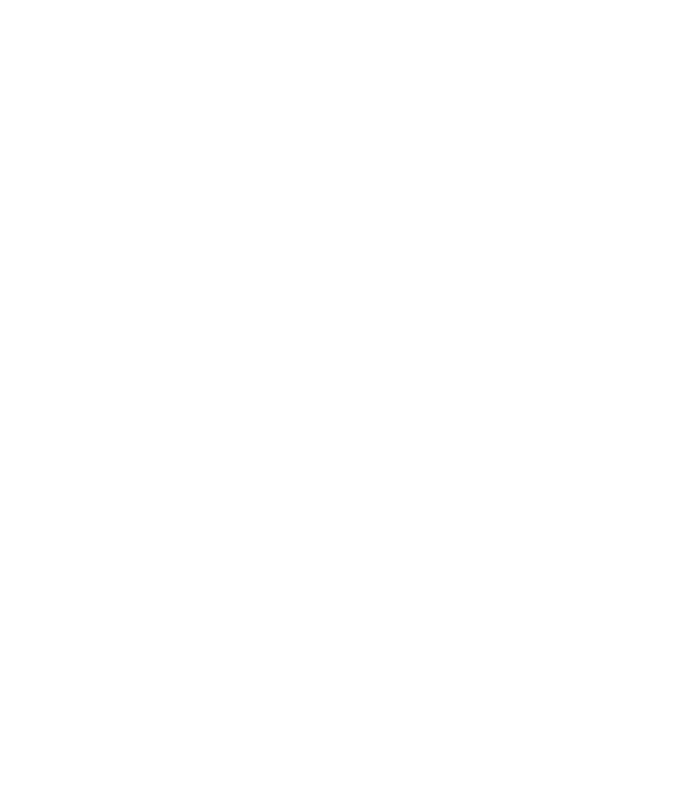

<IPython.core.display.Javascript object>


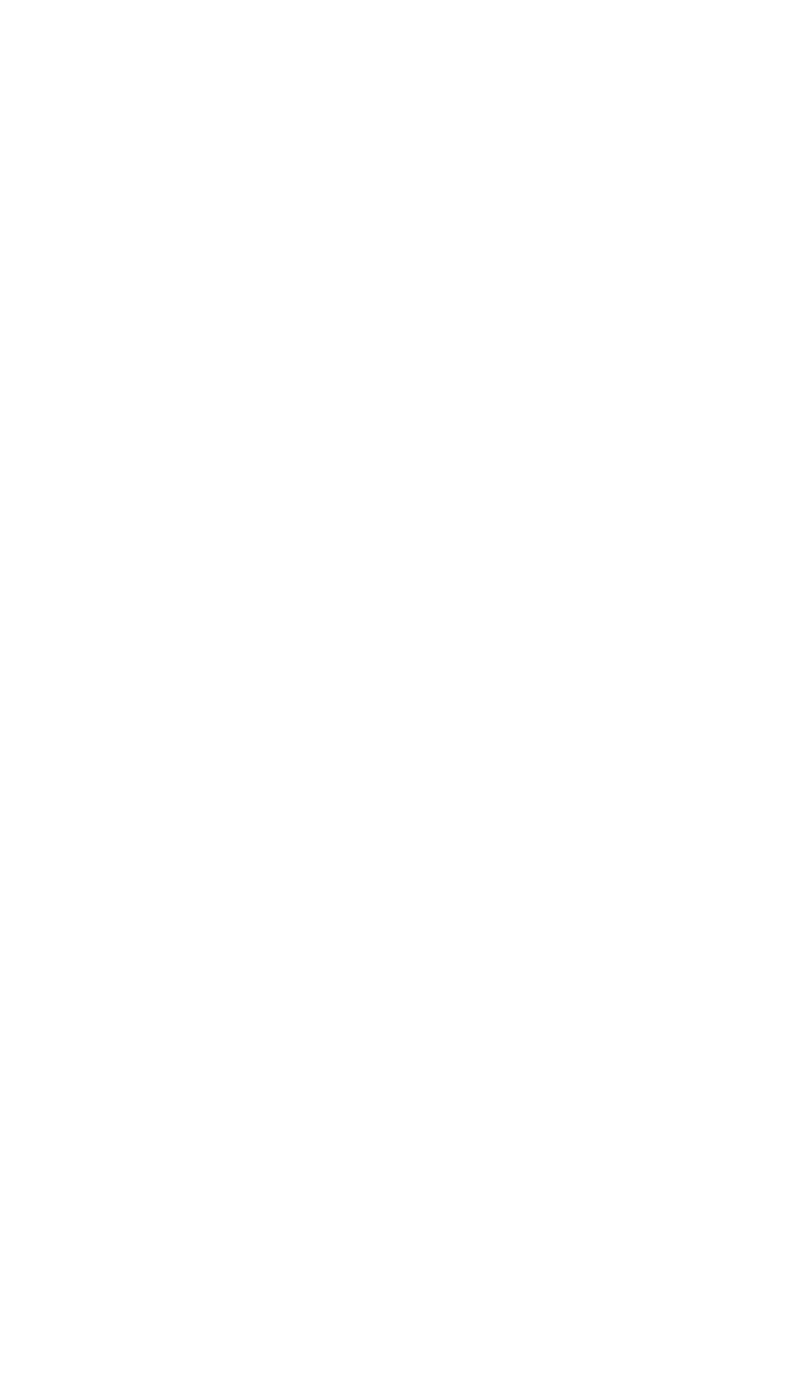

<IPython.core.display.Javascript object>


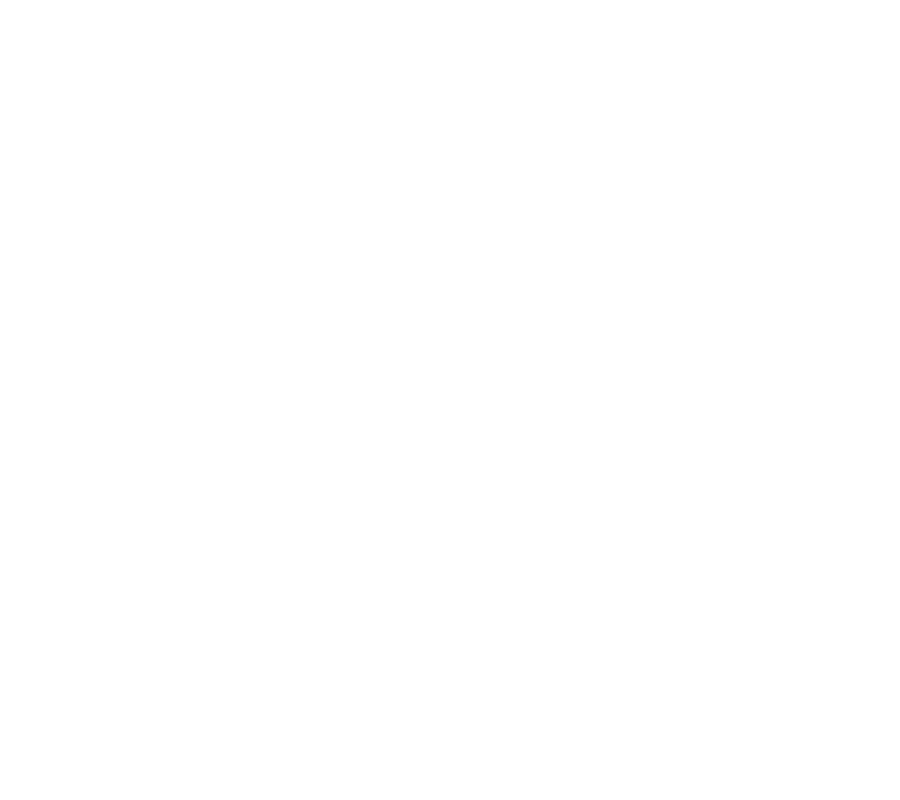

<IPython.core.display.Javascript object>


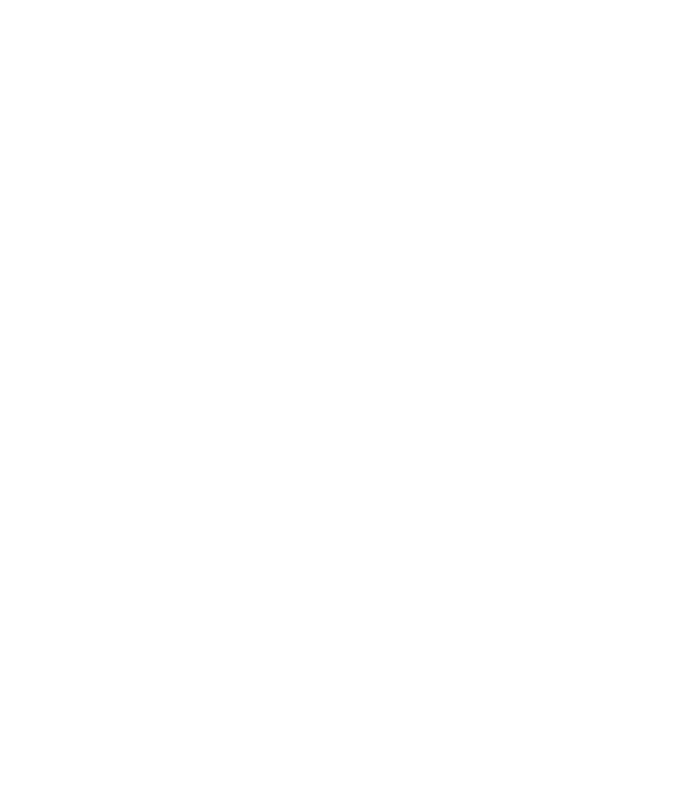

<IPython.core.display.Javascript object>


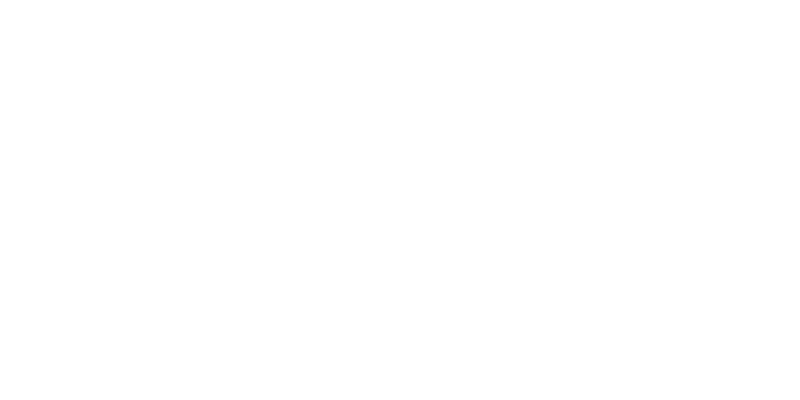

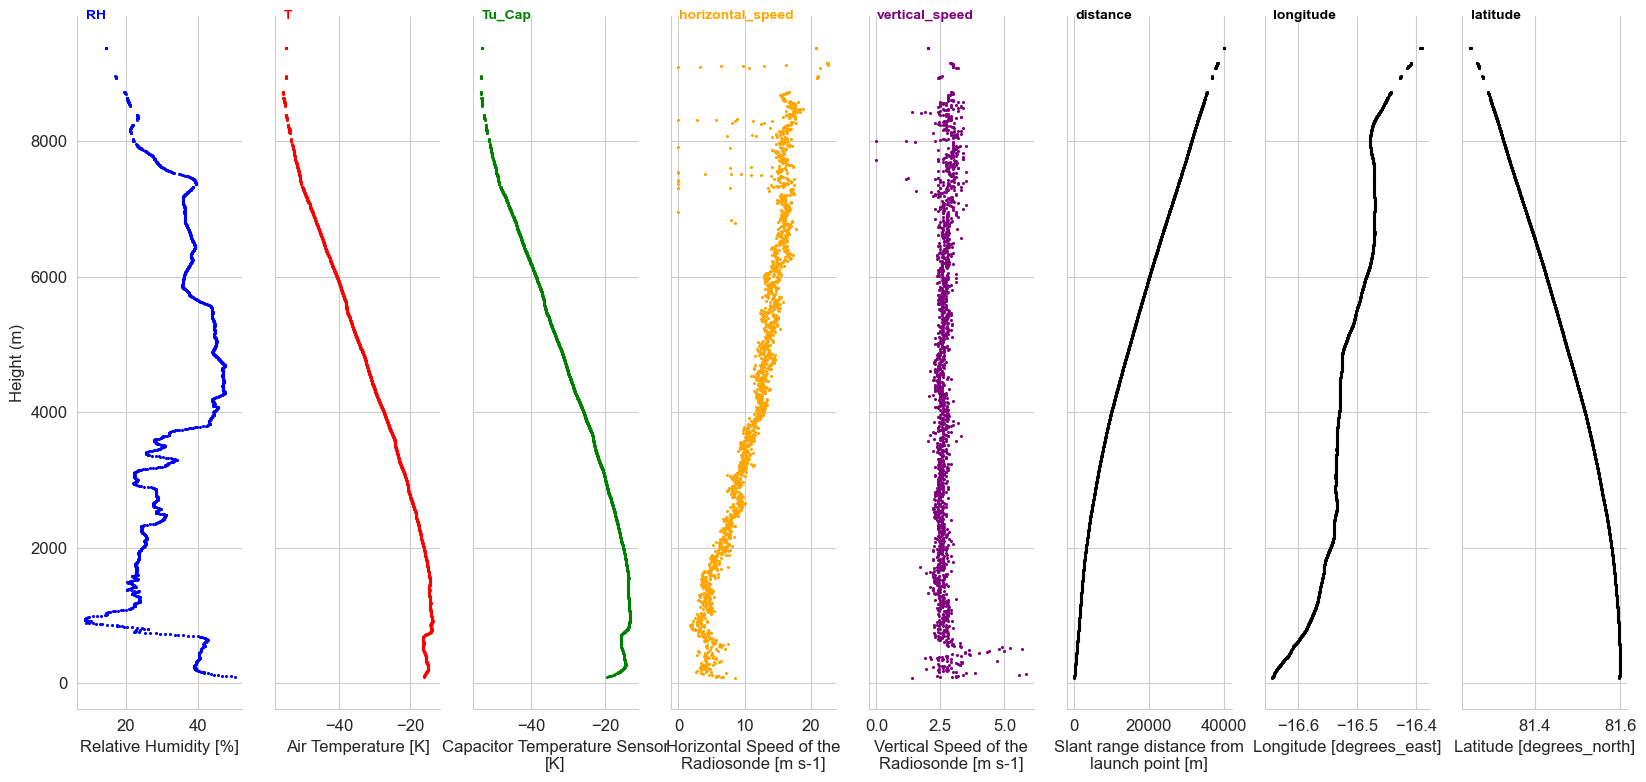

In [33]:
%matplotlib inline
checkL2plots.plot_radiosonde(rs_ds,flight,date)